# Projet n°10 Détection de faux billets

![Google logo](https://or-argent.eu/wp-content/uploads/2016/02/billet-500-eur.jpg "google logo")

# Importation des librairies et des Datas

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import metrics
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.metrics import  accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Pour les outliers (valeur abérante) il faut un dataset avec des valeurs quantitative int ou float;
# Selectionner à la question show or delete, repondre "show" pour voir les valeurs abérante et delete si on veut les supprimer du dataset.
import pandas as pd 
def outliers(data):
    global show
    global count
    global delete
    q1=data.quantile(q=0.25)
    q3=data.quantile(q=0.75)
    IQR=q3-q1
    borne_inf = q1-1.5*IQR  
    borne_sup = q3 +1.5*IQR
    show_inf = borne_inf.dropna()
    show_sup = borne_sup.dropna()
    count = data[data > borne_sup].count() + data[data < borne_inf].count()
    delete = data[(data < borne_sup) & (data > borne_inf)]
    choice = ""
    while choice != "exit":
        choice = input("show, count or delete outliers ? (help to understand choices)")
        if choice == "show":
            print("les valeurs abérantes inferieur:\n", show_inf, "\nles valeurs abérantes supérieur:\n", show_sup)
        elif choice == "count":
            print("le nombre de valeurs abérantes est de:\n", count)
        elif choice == "delete":
            print("le dataset est maintenant supprimé des valeurs abérantes; \n", pd.DataFrame(delete))
        else: 
            print("please choose show, count or delete or exit ")

In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [4]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [5]:
billet = pd.read_csv('C:/Users/benmi/Documents/Data Analyst/P_10/billets.csv', sep= ';')

# Nettoyage des données

In [6]:
billet.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [7]:
billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [8]:
# vrai/faux billets

In [9]:
billet.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

## Régression lineaire pour predir les valeurs manquantes


In [10]:
#Ici nous pouvons constater qu'il manque des valeurs manquantes sur la variable "margin_low",
# plutot que de supprimer ces elements correspondant nous allons prédir les valeurs manquantes

In [11]:
data_noNa = billet.dropna()

In [12]:
data_NaN = billet[billet.isnull().any(axis=1)]

In [13]:
data_noNa.shape

(1463, 7)

In [14]:
data_NaN.shape

(37, 7)

In [15]:
# Creation de X_train et Y_train:
X = data_noNa.drop("margin_low", axis=1)
Y = data_noNa["margin_low"]

In [16]:
# Regression lineaire:
linear_model = LinearRegression()

In [17]:
linear_model.fit(X, Y)

LinearRegression()

In [18]:
x_pred = data_NaN.drop("margin_low", axis = 1)

In [19]:
x_pred.shape

(37, 6)

In [20]:
y_pred = linear_model.predict(x_pred)
# nous prédisons les 37 valeurs manquantes grâce à la regression linéaire

In [21]:
y_pred.shape

(37,)

In [22]:
y_pred #nos 37 données 

array([4.06495361, 4.11199026, 4.13400328, 3.99357074, 4.1403993 ,
       4.09428392, 4.07412432, 4.12538999, 4.0807278 , 4.07363322,
       4.11897255, 4.18037978, 4.13648423, 4.05106842, 4.17837685,
       4.22555104, 4.11586845, 4.10284101, 4.08184346, 4.09276238,
       4.11250192, 4.15717623, 4.16028787, 4.12193808, 4.12353555,
       4.19842271, 4.10962313, 4.09696025, 4.13384101, 5.25968515,
       5.264817  , 5.28251853, 5.30206887, 5.20035843, 5.1754678 ,
       5.17345045, 5.24675055])

In [23]:
data_NaN["margin_low"] = y_pred  #integration des nouvelles données dans notre dataframe data_NaN

C:\Users\benmi\AppData\Local\Temp/ipykernel_8360/2334114289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NaN["margin_low"] = y_pred  #integration des nouvelles données dans notre dataframe data_NaN


In [25]:
data_NaN.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.064954,3.25,112.79
99,True,171.93,104.07,104.18,4.111990,3.14,113.08


In [26]:
data_noNa=data_noNa.append(data_NaN,ignore_index=True)
#Ici nous avons récup les 37 valeurs prédites et nous les AJOUTONS à notre df "data_noNA" pour ainsi avoir un tableau de 
# 1500 lignes avec 0 valeur manquante

In [27]:
billets = data_noNa # dataframe final

In [28]:
# Instanciation:
import statsmodels.formula.api as smf
reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = billets)
res_lin = reg_linb.fit()
res_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     275.2
Date:                Sat, 30 Jul 2022   Prob (F-statistic):          7.84e-209
Time:                        19:45:12   Log-Likelihood:                -1014.7
No. Observations:                1500   AIC:                             2041.
Df Residuals:                    1494   BIC:                             2073.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       23.2304      9.470      2.453      0.014       4.655      41.806
diagonal        -0.1116      0.041     -2.748      0.006      -0.191      -0.032
height_left      0.1863      0.044      4.232      0.000       0.100       0.273
height_right     0.2542      0.042      6.062      0.000       0.172       0.336
margin_up        0.2436      0.063      3.869      0.000       0.120       0.367
length          -0.4093      0.018    -23.111      0.000      -0.444      -0.375
==============================================================================
Omnibus:                       78.472   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.157
Skew:                           0.489   Prob(JB):                     2.41e-23
Kurtosis:                       3.843   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

47% des données correspondent aux données du model linéaire. R² (R-squared) qui varie la qualité d'ajustement du model varie entre 0 et 1. Plus on est proche de 1 plus le modele est juste et au contraire plus on s'approche de 0 plus le modele est imprécis. Ici 47% n'est pas trop mal mais il n'est pas très optimal non plus.

Ce qui nous intéresse réellement, c'est le test de Fisher. La p-valeur de ce test (Prob (F-statistic): 7.84e-209 < 5% ) est très petite et largement inférieure à 5 %. On rejette donc l'hypothèse H0 selon laquelle  α1=α2=α3=α4=α5=0 .

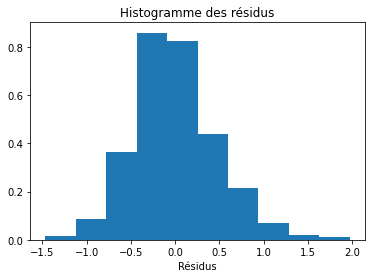

In [29]:
plt.hist(res_lin.resid, density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

# Résidu = Valeur observée – Valeur estimée

In [30]:
from scipy.stats import shapiro

In [31]:
 shapiro(res_lin.resid)

ShapiroResult(statistic=0.9853824973106384, pvalue=3.520380167931769e-11)

Le test de Saphiro Wilk nous permet de savoir si une distribution est normale
Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

# Analyse descriptive de nos données 

In [32]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [33]:
def box(X):
    modalites = billets['is_genuine'].unique()
    groupes = []

    for m in modalites:
      groupes.append(billets[billets['is_genuine']==m][X])

    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
    plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.xlabel(X,fontsize=15)
    plt.ylabel("Vrai/Faux billets",fontsize=15)
    plt.show()
    

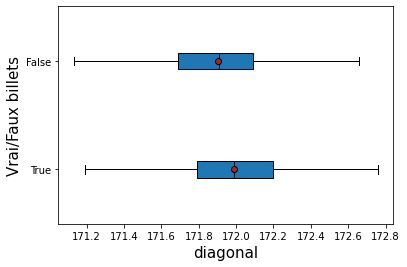

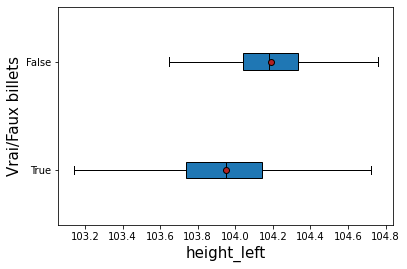

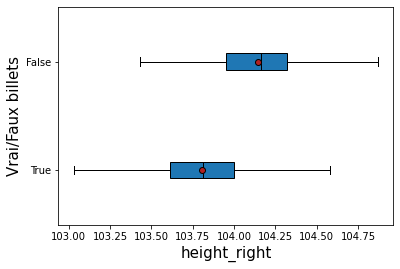

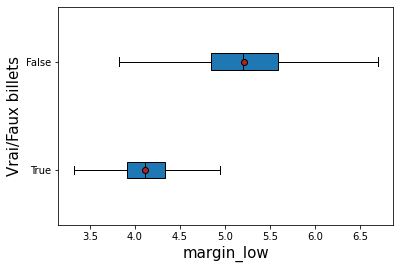

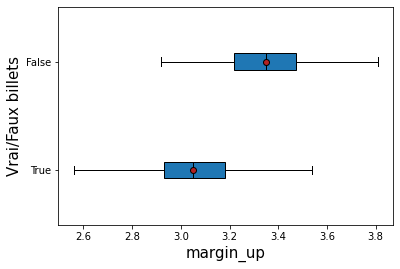

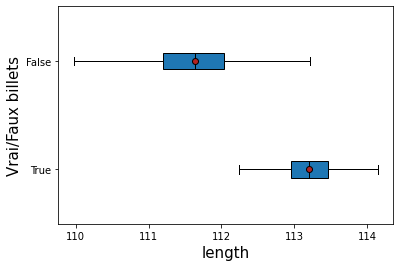

In [34]:
l=['diagonal','height_left','height_right' ,'margin_low' ,'margin_up' ,'length']
for i in l:
    box(i)

In [35]:
# Ci dessus nous pouvons constater la diagonal des vrais et faux billets est similaire. Je vais garder cette variable car 
# on peut trouver des valeurs hors du commun

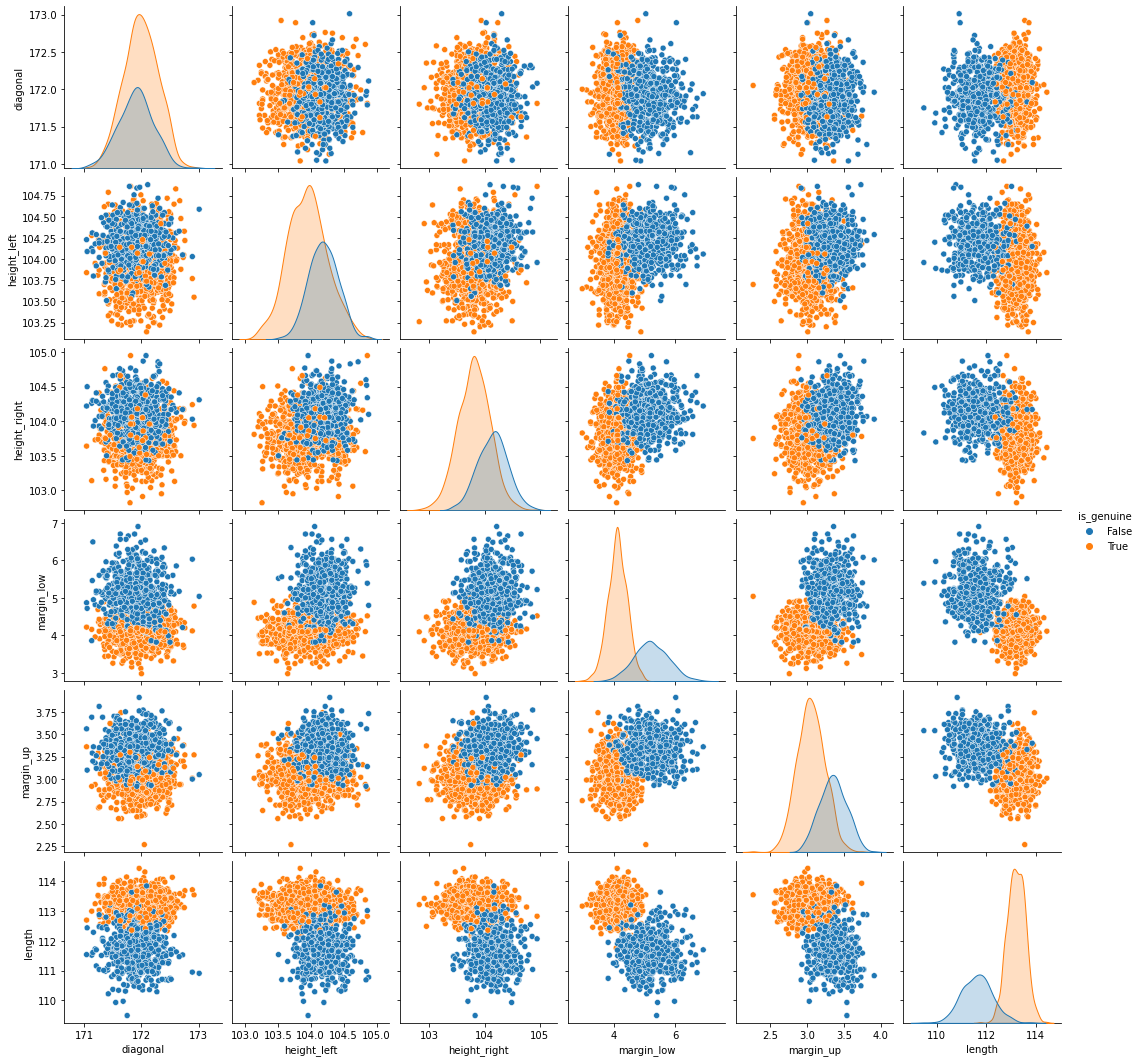

In [36]:
# Visualisation des correlations avec comme indicateur de couleur les vrais et faux billets;
sns.pairplot(billets, hue="is_genuine")
plt.show()

Observation : Concernant la diagonal /hauteur(L&R) on une faible contribution dans la distingtion entre les faux et les vrais billets
Une distection est notable avec les virables length / margin_low

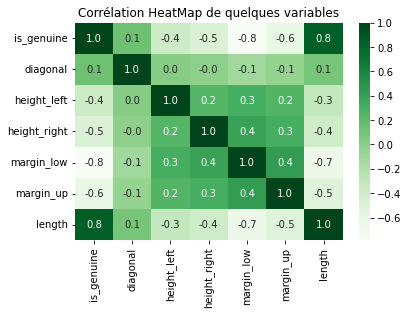

In [37]:
# Matrice de correlation
sns.heatmap(billets.corr(), annot=True, fmt=".1f", cmap='Greens')
plt.title('Corrélation HeatMap de quelques variables')
plt.show()


# Réalisation de l'ACP

### Normalisation des données / Centre - Reduite

In [38]:
x = billets.select_dtypes('number')
print('x', x.shape)

x (1500, 6)


In [39]:
from sklearn import preprocessing

In [40]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(x)
X_scaled = pd.DataFrame(X_scaled, index=x.index, columns=x.columns)
print('X_scaled', X_scaled.shape)

X_scaled (1500, 6)


In [41]:
# verif moyenne par colonne = 0 et verif ecart = 1
X_scaled.mean(axis=0), X_scaled.std(axis=0)

(diagonal        1.464536e-14
 height_left     4.791974e-14
 height_right   -2.776801e-14
 margin_low     -3.369157e-16
 margin_up      -3.731090e-16
 length          1.402434e-15
 dtype: float64,
 diagonal        1.000334
 height_left     1.000334
 height_right    1.000334
 margin_low      1.000334
 margin_up       1.000334
 length          1.000334
 dtype: float64)

**MISE EN PLACE DE L'ACP**

In [42]:
#define PCA model to use
pca = PCA()

#fit PCA model to data
X_reduced = pca.fit_transform(X_scaled)

In [43]:
x = X_scaled.select_dtypes('number')
print('x', x.shape)

x (1500, 6)


In [44]:
# Ce qui nous interesse c'est d'avoir le moins de perte d'informations possible sur la visualisation (axe inertie)

In [45]:
pca_columns = ['PC'+ str(c) for c in range(1, X_reduced.shape[1]+1, 1)]
X_reduced = pd.DataFrame(X_reduced, index=x.index, columns=pca_columns)
X_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.647524,0.746876,2.392915,3.186405,0.305766,-0.011945
1,-2.019703,-2.206746,-1.002619,0.070913,0.037255,-0.475099
2,-0.969007,2.619321,1.201967,-0.921319,-0.837793,0.197210
3,-1.375629,-1.817808,0.646521,0.830747,0.804194,-0.225359
4,0.150222,-0.566097,0.854019,-1.784685,1.184748,-0.291198


In [46]:
explained_variance = pd.Series(dict(zip(X_reduced.columns, 100.0*pca.explained_variance_ratio_)))
explained_variance.head()

PC1    43.211292
PC2    16.957177
PC3    13.019270
PC4    11.824046
PC5     9.663102
dtype: float64

**Bonne nouvelle ! On observe que les composantes PC1 + PC2 representent ensemble 60% du résultat ! c'est suffisant pour s'en servir**

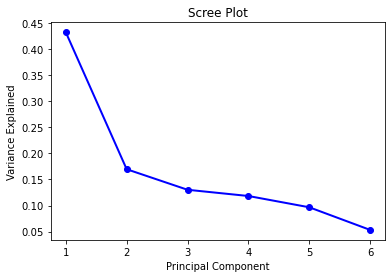

In [47]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

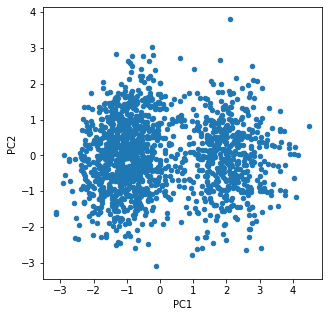

In [48]:
X_reduced.plot(x='PC1', y='PC2', kind='scatter', figsize=(5,5))

#Nous avons projeté visuellement les points sur PC1 et PC2, maintenant, interessons nous à leur représentativité

### Realisation du Cercle de corrélation 

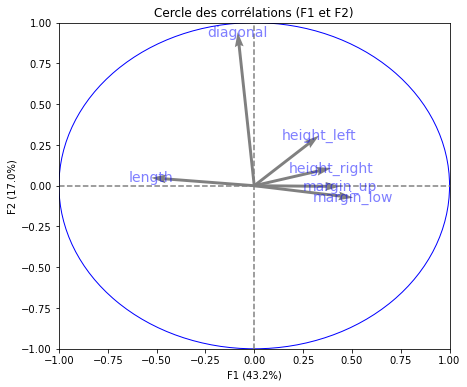

In [49]:
# Cercle des corrélations
features = X_scaled.columns
pcs = pca.components_
display_circles(pcs, 8, pca, [(0,1)], labels = np.array(features))

height = taille  ///   lenght = longueur                     

Ici l'axe X (PC1) pourrait representer la hauteur, la marge et la longueur   
L'axe Y (PC2) pourrait représenter la diagonal

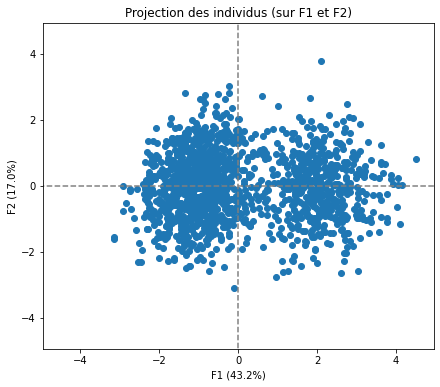

In [50]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, 8, pca, [(0,1)])

plt.show()   

L'objectif de l'ACP est d'observer nos données sous un angle different <br/> Ici nous pouvons constater qu'il y a bien 2 groupes distincts: Vrai / Faux billets

# Détection des faux billets

## Logisitic regression

In [51]:
#Préparation des données d'entrainement
y = billets.iloc[:,:1]
X = billets.iloc[:,1:8]
print(y.shape)
print(X.shape)

(1500, 1)
(1500, 6)


In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
#Division de la base de données
X = StandardScaler().fit(X).transform(X)

x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1200, 6)
(300, 6)
(1200, 1)
(300, 1)


In [54]:
#Création du modèle
Logistic_model = LogisticRegression()
Logistic_model.fit(x_train, y_train)

C:\Users\benmi\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [55]:
from joblib import Parallel, delayed
import joblib
 
 
# Save the model as a pickle in a file
joblib.dump(Logistic_model, 'Logistic_model.pkl')

['Logistic_model.pkl']

In [56]:
# Evaluation de phase training
score_model = Logistic_model.score(x_train,y_train)
score_model
# On a une precision de 99% ds la data de training, notre model obtient un score de 99% ce qui nous permet de dire 
# qu'il y a une grande précision dans le model de donnée

0.9933333333333333

In [57]:
#test model
predictions = Logistic_model.predict(x_test)

La précision (precision en anglais) et le rappel (recall en anglais) sont deux métriques pour évaluer la performance des modèles de classification à 2 classes ou plus. Ces métriques sont basées sur la matrice de confusion ↓ ↓ ↓


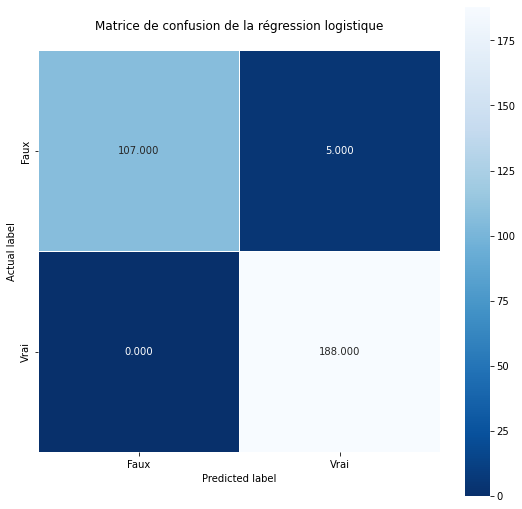

In [58]:
# test du model;

cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r'
,xticklabels = ["Faux","Vrai"],yticklabels=["Faux","Vrai"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion de la régression logistique\n")
plt.show()

Element à observer en particulier : *Billet Faux positif*

In [59]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, predictions))
#niveau de précision

              precision    recall  f1-score   support

       False       1.00      0.96      0.98       112
        True       0.97      1.00      0.99       188

    accuracy                           0.98       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



La precision et le recall sont deux métriques qui se concentrent sur la performance du modèle concernant les individus positifs :

- La precision est également appelée Positive Predictive Value.
Elle correspond au taux de prédictions correctes parmi les prédictions positives c-a-d elle mesure la capacité du modèle à ne pas faire d’erreur lors d’une prédiction positive.

- Le recall est également appelé sensitivity (sensibilité), true positive rate ou encore hit rate (taux de détection). Il correspond au taux d’individus positifs détectés par le modèle : Il mesure la capacité du modèle à détecter l’ensemble des individus positifs.

In [60]:
# Évaluation de la phase test:
class_test = metrics.accuracy_score(y_test, predictions)
pred_test = metrics.precision_score(y_test, predictions)
rappel_test = metrics.recall_score(y_test, predictions)
print("La précision de la classification est de: {}".format(round(class_test*100)), "%")
print("La précision de la prédiction est de: {}".format(round(pred_test*100)), "%")
print("La précision de rappel est de: {}".format(round(rappel_test*100)), "%")


La précision de la classification est de: 98 %
La précision de la prédiction est de: 97 %
La précision de rappel est de: 100 %


Nous avons un modele qui a une precision très eleve de 99% ce qui nous permet de valider la phase de test.

In [61]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

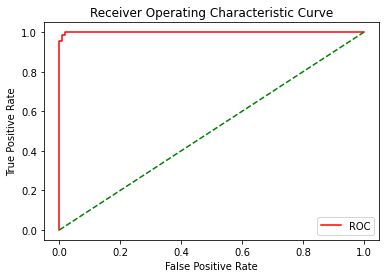

In [62]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()


prob = Logistic_model.predict_proba(x_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)

True Positive Rate = Sensitivity = True Positive / (True Positive + False Negatives)

La courbe de Curve nous confirme que nous avons une excellente précision car nous sommes près de 1

*En conclusion, les métriques d'évaluation que nous obtenons sont très satisfaisantes. Après l'évaluation des performances du modèle de prédiction 'lr', ce modèle est retenu pour sa fiablité et sa performance.*

## Kmeans

Algo non supervisé

C:\Users\benmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


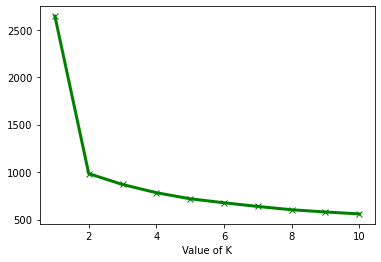

In [63]:
# Méthode Elbow 
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500, random_state = 0) 
    KM.fit(billets) 
    cost.append(KM.inertia_)      
plt.plot(range(1, 11), cost, color ='g', linewidth ='3',marker="x") 
plt.xlabel("Value of K") 
plt.show() 

In [64]:
kmeans = KMeans(n_clusters= 2)

In [65]:
kmeans = kmeans.fit(x_train)

In [66]:
kmeans_predict = kmeans.predict(x_train)

In [67]:
data_train_clusters = pd.DataFrame(y_train)
data_train_clusters["clusters_km"] = kmeans_predict

In [68]:
data_train_clusters.head(5)

,is_genuine,clusters_km
321,True,1
1251,False,0
1149,False,0
523,True,1
102,True,1


In [69]:
#Tableau des correspondances clusters/nature billets
tableau = pd.crosstab(data_train_clusters["is_genuine"], data_train_clusters["clusters_km"], margins=False)
tableau.columns = ['Cluster 0 - Faux','Cluster 1 - Vrai']
tableau.index = ['i_g 0 - Faux','i_g 1 - Vrais']
tableau

,Cluster 0 - Faux,Cluster 1 - Vrai
i_g 0 - Faux,379,9
i_g 1 - Vrais,9,803


In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
#classification des points du jeu de test par l'algotithme Kmeans
df_x_test = pd.DataFrame(x_test)

In [72]:
kmeans_predict = kmeans.predict(x_test)

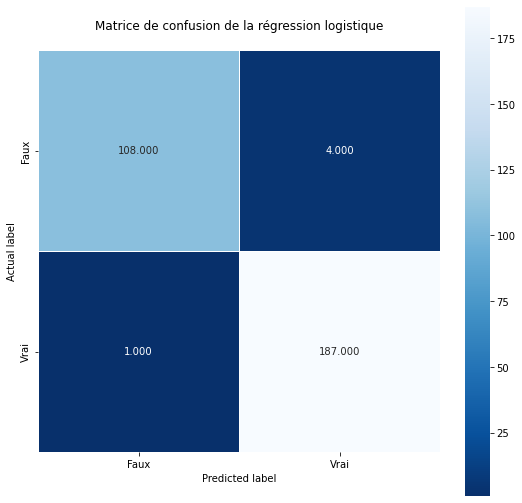

In [73]:
# test du model;

cm2 = metrics.confusion_matrix(y_test, kmeans_predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r'
,xticklabels = ["Faux","Vrai"],yticklabels=["Faux","Vrai"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion de la régression logistique\n")
plt.show()

In [74]:
metrics.accuracy_score(y_test, kmeans_predict)

0.9833333333333333

In [75]:
class_kmeans_test = metrics.accuracy_score(y_test, kmeans_predict)
pred_kmeans_test = metrics.precision_score(y_test, kmeans_predict)
rappel_kmeans_test = metrics.recall_score(y_test, kmeans_predict)
print("La précision de la classification est de: {}".format(round(class_kmeans_test*100)), "%")
print("La précision de la prédiction est de: {}".format(round(pred_kmeans_test*100)), "%")
print("La précision de rappel est de: {}".format(round(rappel_kmeans_test*100)), "%")


La précision de la classification est de: 98 %
La précision de la prédiction est de: 98 %
La précision de rappel est de: 99 %


Le model Kmeans est très performant au vu des resultats que nous avons, tout comme la regression logisitique 

*Pour la suite nous deciderons d'utiliser le modele de regression logistique car plus performant (99/100/99)*

In [76]:
kmeans.cluster_centers_

array([[-0.19137896,  0.57563226,  0.70000145,  1.11215767,  0.8538022 ,
        -1.19063672],
       [ 0.10017413, -0.27102424, -0.35588924, -0.54860093, -0.42114343,
         0.5986954 ]])

In [77]:
from matplotlib.pyplot import figure


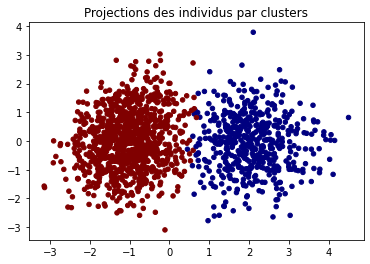

In [78]:
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=kmeans.predict(X_scaled), cmap = 'jet', s=20)
plt.title("Projections des individus par clusters")
plt.show()

Ici nous pouvons voir et comparer si notre algorithme a bien classé les billets


# Fonction pour tester le model sur nouveaux Dataset

In [79]:
billet_a_prediction = pd.read_csv('C:/Users/benmi/Documents/Data Analyst/P_10/billets_production.csv', sep= ',')

In [80]:
billet_a_prediction

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [81]:
billet_a_prediction = billet_a_prediction.set_index('id')

In [82]:
billet_a_prediction

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42
A_2,171.87,104.17,104.13,6.00,3.31,112.09
A_3,172.00,104.58,104.29,4.99,3.39,111.57
A_4,172.49,104.55,104.34,4.44,3.03,113.20
A_5,171.65,103.63,103.56,3.77,3.16,113.33


In [83]:
# Load the model from the file
Logistic_model_from_joblib = joblib.load('Logistic_model.pkl')

In [84]:
billet_a_prediction_std = StandardScaler().fit(billet_a_prediction).transform(billet_a_prediction)

In [85]:
billet_a_prediction_std

array([[-0.66422777, -0.50222407, -1.22890038,  0.43822393,  0.48568108,
        -1.12401394],
       [-0.28760378, -0.0507867 ,  0.44945894,  1.4937023 ,  0.56401673,
        -0.28910336],
       [ 0.15749731,  1.10602155,  0.90460723,  0.14429325,  1.19070199,
        -0.93709366],
       [ 1.83518602,  1.02137704,  1.04684107, -0.59053347, -1.62938167,
         1.09410669],
       [-1.04085177, -1.57438781, -1.17200685, -1.48568601, -0.61101813,
         1.25610427]])

In [86]:
# mise en service de notre model de regression logistique qu'on a appelé plus tot "Logistic_model"
pred = Logistic_model_from_joblib.predict(billet_a_prediction_std)
proba = Logistic_model_from_joblib.predict_proba(billet_a_prediction_std)
billet_a_prediction["prediction"] = pred
proba = proba[:,1]
billet_a_prediction['proba'] = proba

In [87]:
billet_a_prediction

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,proba
id,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,False,0.047088
A_2,171.87,104.17,104.13,6.00,3.31,112.09,False,0.014995
A_3,172.00,104.58,104.29,4.99,3.39,111.57,False,0.007851
A_4,172.49,104.55,104.34,4.44,3.03,113.20,True,0.999919
A_5,171.65,103.63,103.56,3.77,3.16,113.33,True,0.999998


In [88]:
# proba : % de probabilité l'evenement à predir = billet vrai

TEST SUR NOUVEAUX BILLETS

In [89]:
def Algo_prediction_faux_billets(data):
    data_std = StandardScaler().fit(data).transform(data)
    pred = Logistic_model_from_joblib.predict(data_std)
    proba = Logistic_model_from_joblib.predict_proba(data_std)
    data["prediction"] = pred
    proba = proba[:,1]
    data['proba'] = proba
    return data

#ci-dessus j'ai crée ma fonction algorithmique pour detetecter des vrais/faux billets grâce à la reg logistique vu plus haut

In [90]:
test = pd.read_csv('C:/Users/benmi/Documents/Data Analyst/P_10/billets_test.csv')

In [91]:
test = test.set_index('id')
test

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
B_1,172.09,103.95,103.73,4.39,3.09,113.19
B_2,171.52,104.17,104.03,5.27,3.16,111.82
B_3,171.78,103.80,103.75,3.81,3.24,113.39
B_4,172.02,104.08,103.99,5.57,3.30,111.10
B_5,171.79,104.34,104.37,5.00,3.07,111.87


In [92]:
Algo_prediction_faux_billets(test)

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,proba
id,,,,,,,,
B_1,172.09,103.95,103.73,4.39,3.09,113.19,True,0.999967
B_2,171.52,104.17,104.03,5.27,3.16,111.82,False,0.104732
B_3,171.78,103.80,103.75,3.81,3.24,113.39,True,0.999977
B_4,172.02,104.08,103.99,5.57,3.30,111.10,False,0.000232
B_5,171.79,104.34,104.37,5.00,3.07,111.87,False,0.449841


**Nous avons 3 billets faux et 2 billets bons**